In [2]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, LeakyReLU, Embedding, multiply
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

In [3]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler

def load_and_preprocess_data(main_folder_path):
    """Loads and preprocesses data from a folder containing subfolders A-E with .txt/.TXT files.

    Args:
        main_folder_path: Path to the main folder.

    Returns:
        Tuple: (X, y) where X is the feature matrix and y is the label vector.
               Returns None, None if there's an error.
    """
    X = []
    y = []
    labels = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}

    try:
        for folder_name, label in labels.items():
            folder_path = os.path.join(main_folder_path, folder_name)
            if not os.path.isdir(folder_path):
                print(f"Warning: Folder {folder_path} not found. Skipping.")
                continue

            for filename in os.listdir(folder_path):
                if filename.lower().endswith(".txt"):  # Case-insensitive check for .txt
                    file_path = os.path.join(folder_path, filename)
                    try:
                        # Load data from text file, assuming space separation
                        data = np.loadtxt(file_path)
                        if data.ndim == 1: #Check if the data is 1d or 2d
                            data = data.reshape(1, -1) #Reshape to 2d if it's 1d
                        X.extend(data[:, :-1]) #Extend the data from all rows and all columns except the last one
                        y.extend([label] * data.shape[0]) #Extend the labels based on the number of rows
                    except ValueError:
                        print(f"Error reading data from {file_path}. Check file format (likely non-numeric data). Skipping.")
                    except Exception as e:
                        print(f"An error occurred while processing {file_path}: {e}")

        if not X:
            print("No data loaded. Check the folder paths, file formats, and file content.")
            return None, None
            
        X = np.array(X)
        y = np.array(y)
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
        return X, y

    except FileNotFoundError:
        print(f"Error: Main folder not found at {main_folder_path}")
        return None, None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None, None


In [4]:
def create_binary_labels(y):
    """Creates binary labels (1: Ictal, 0: Non-ictal)."""
    return np.where(y == 1, 1, 0)

def create_three_class_labels(y):
    """Creates three-class labels (0: Ictal, 1: Tumor, 2: Eyes)."""
    mapping = {1: 0, 2: 1, 3: 1, 4: 2, 5: 2}
    return pd.Series(y).map(mapping).values

In [5]:
def train_and_evaluate(X_train, y_train, X_test, y_test, model, model_name):
    """Trains and evaluates a given model."""
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"---{model_name}---")
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non-Ictal', 'Ictal'] if len(np.unique(y_test))==2 else (['Ictal', 'Tumor', 'Eyes'] if len(np.unique(y_test))==3 else ['Ictal', 'Tumor Location', 'Healthy Brain', 'Eyes Closed', 'Eyes Open']), 
                yticklabels=['Non-Ictal', 'Ictal'] if len(np.unique(y_test))==2 else (['Ictal', 'Tumor', 'Eyes'] if len(np.unique(y_test))==3 else ['Ictal', 'Tumor Location', 'Healthy Brain', 'Eyes Closed', 'Eyes Open']))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()
    return accuracy_score(y_test, y_pred)

In [6]:
def create_mlp_model(input_dim, num_classes):
    """Creates a basic MLP model for classification.

    Args:
        input_dim: Dimensionality of the input features.
        num_classes: Number of output classes for the classifier.

    Returns:
        A compiled Keras sequential model.
    """
    model = Sequential([
        layers.Input(shape=(input_dim,)),  # Correct input shape
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])  # Correct closing bracket
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [7]:
file_path = '/Users/mohamedeldagla/Desktop/senior year/New Trends in AI/Epilepsy - GANs/Data' # Replace with the path to your main folder
X, y = load_and_preprocess_data(file_path)

if X is not None and y is not None:
    print("Data loaded successfully.")
    print("Shape of X:", X.shape)
    print("Shape of y:", y.shape)
else:
    print("Data loading failed.")

Data loaded successfully.
Shape of X: (500, 4096)
Shape of y: (500,)



--- Binary Classification (Original Data) ---
---Logistic Regression---
              precision    recall  f1-score   support

           0       0.82      0.85      0.83        80
           1       0.29      0.25      0.27        20

    accuracy                           0.73       100
   macro avg       0.56      0.55      0.55       100
weighted avg       0.71      0.73      0.72       100



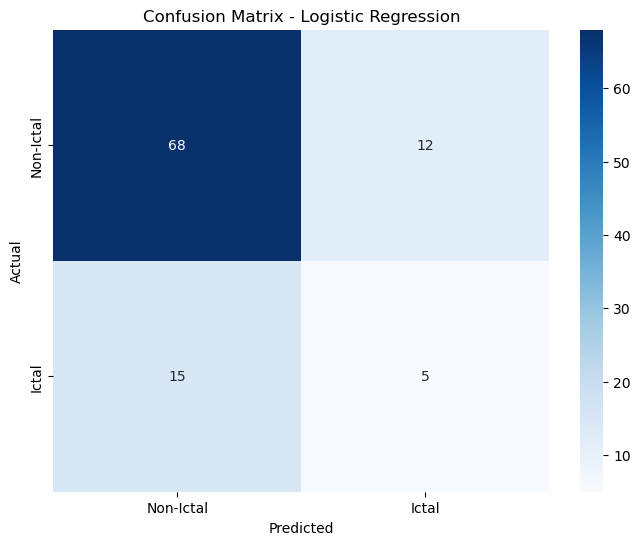

---Random Forest---
              precision    recall  f1-score   support

           0       0.81      0.99      0.89        80
           1       0.67      0.10      0.17        20

    accuracy                           0.81       100
   macro avg       0.74      0.54      0.53       100
weighted avg       0.78      0.81      0.75       100



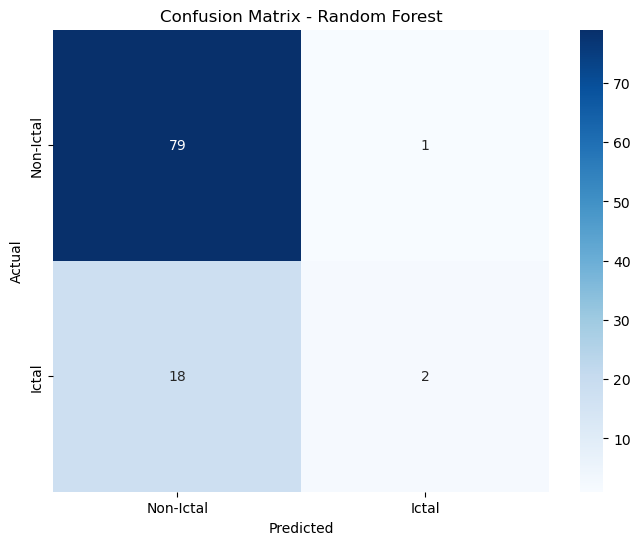

---MLP---
MLP Accuracy: 0.7799999713897705
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


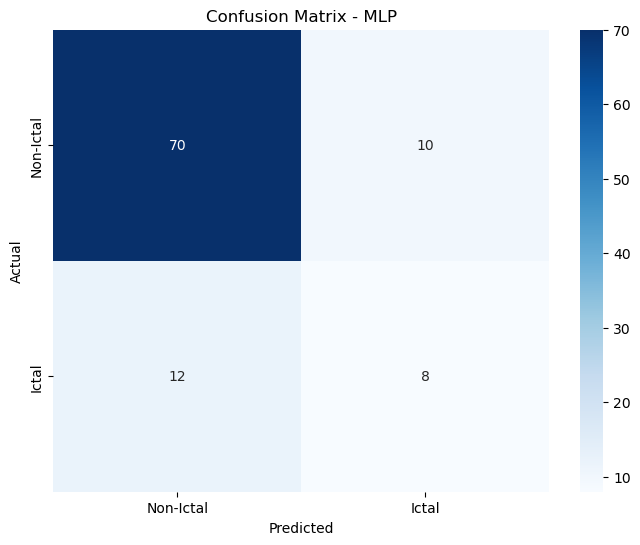

In [8]:
y_binary = create_binary_labels(y)
X_train_binary, X_test_binary, y_train_binary, y_test_binary = train_test_split(X, y_binary, test_size=0.2, random_state=42, stratify=y_binary)
smote = SMOTE(random_state=42)
X_train_binary_resampled, y_train_binary_resampled = smote.fit_resample(X_train_binary, y_train_binary)
print("\n--- Binary Classification (Original Data) ---")
train_and_evaluate(X_train_binary_resampled, y_train_binary_resampled, X_test_binary, y_test_binary, LogisticRegression(), "Logistic Regression")
train_and_evaluate(X_train_binary_resampled, y_train_binary_resampled, X_test_binary, y_test_binary, RandomForestClassifier(), "Random Forest")
mlp_binary = create_mlp_model(X_train_binary.shape[1], 2)
mlp_binary.fit(X_train_binary_resampled, y_train_binary_resampled, epochs=50, batch_size=32, verbose=0)
_, accuracy = mlp_binary.evaluate(X_test_binary, y_test_binary, verbose=0)
print(f"---MLP---")
print(f"MLP Accuracy: {accuracy}")
cm = confusion_matrix(y_test_binary, mlp_binary.predict(X_test_binary).argmax(axis=-1))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Ictal', 'Ictal'], yticklabels=['Non-Ictal', 'Ictal'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - MLP')
plt.show()

##Five Classes


--- Five-Class Classification (Original Data) ---
---Logistic Regression---
              precision    recall  f1-score   support

           0       0.31      0.25      0.28        20
           1       0.36      0.40      0.38        20
           2       0.59      0.95      0.73        20
           3       0.60      0.75      0.67        20
           4       1.00      0.25      0.40        20

    accuracy                           0.52       100
   macro avg       0.57      0.52      0.49       100
weighted avg       0.57      0.52      0.49       100



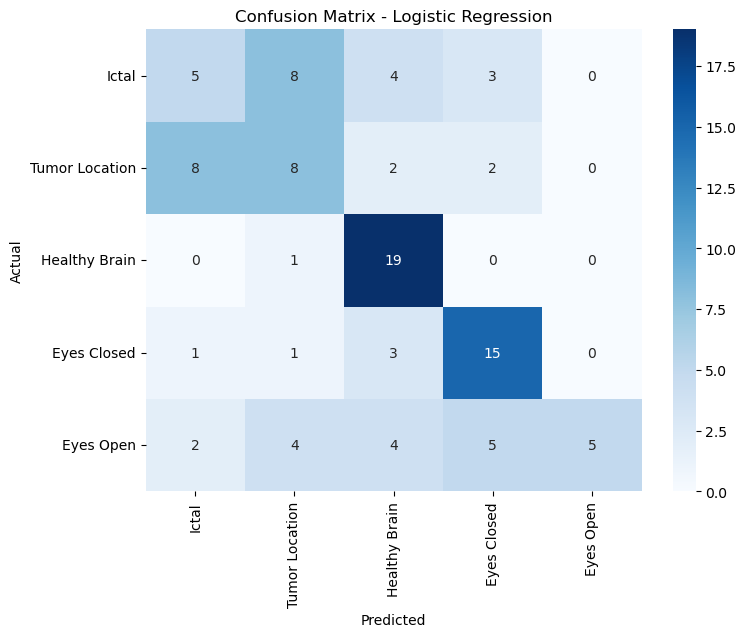

---Random Forest---
              precision    recall  f1-score   support

           0       0.65      0.65      0.65        20
           1       0.48      0.55      0.51        20
           2       0.72      0.65      0.68        20
           3       0.82      0.70      0.76        20
           4       0.82      0.90      0.86        20

    accuracy                           0.69       100
   macro avg       0.70      0.69      0.69       100
weighted avg       0.70      0.69      0.69       100



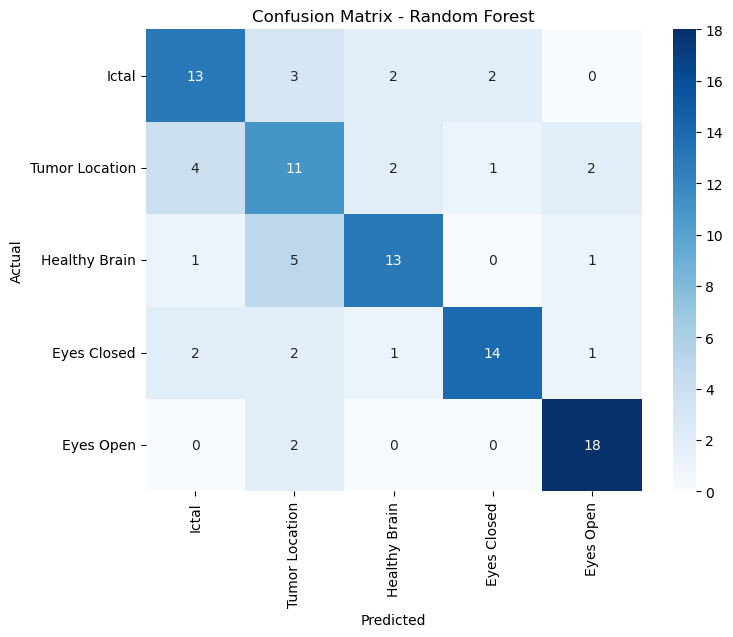

---MLP---
MLP Accuracy: 0.6200000047683716
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


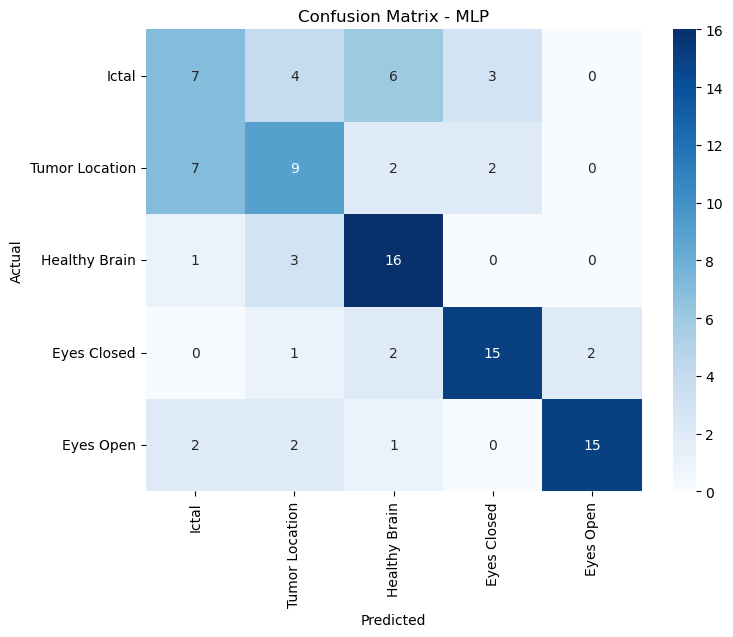

In [9]:
y_five = y
X_train_five, X_test_five, y_train_five, y_test_five = train_test_split(X, y_five, test_size=0.2, random_state=42, stratify=y_five)
smote = SMOTE(random_state=42)
X_train_five_resampled, y_train_five_resampled = smote.fit_resample(X_train_five, y_train_five)
print("\n--- Five-Class Classification (Original Data) ---")
train_and_evaluate(X_train_five_resampled, y_train_five_resampled, X_test_five, y_test_five, LogisticRegression(), "Logistic Regression")
train_and_evaluate(X_train_five_resampled, y_train_five_resampled, X_test_five, y_test_five, RandomForestClassifier(), "Random Forest")
mlp_five = create_mlp_model(X_train_five.shape[1], 5)
mlp_five.fit(X_train_five_resampled, y_train_five_resampled, epochs=50, batch_size=32, verbose=0)
_, accuracy = mlp_five.evaluate(X_test_five, y_test_five, verbose=0)
print(f"---MLP---")
print(f"MLP Accuracy: {accuracy}")
cm = confusion_matrix(y_test_five, mlp_five.predict(X_test_five).argmax(axis=-1))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Ictal', 'Tumor Location', 'Healthy Brain', 'Eyes Closed', 'Eyes Open'], yticklabels=['Ictal', 'Tumor Location', 'Healthy Brain', 'Eyes Closed', 'Eyes Open'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - MLP')
plt.show()




Class Distribution in Training+Validation Set:
y
1    1840
2    1840
3    1840
4    1840
5    1840
Name: count, dtype: int64


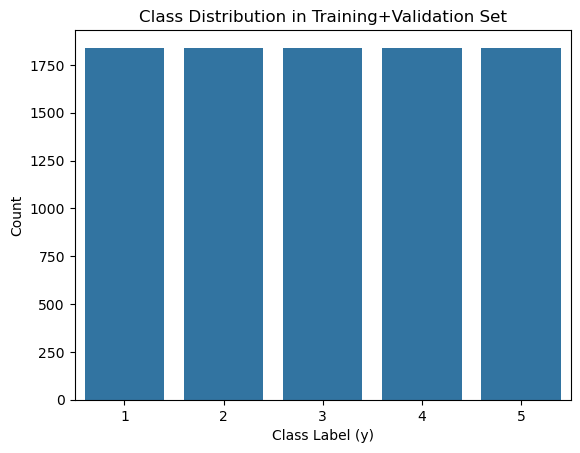


Class Distribution in Testing Set:
y
1    460
2    460
3    460
4    460
5    460
Name: count, dtype: int64


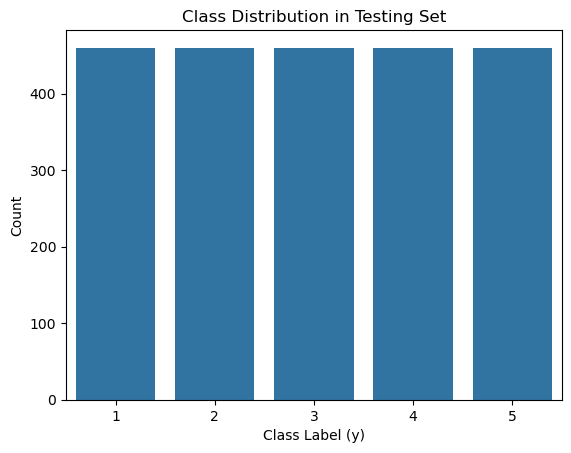

In [15]:
# Function to display class distribution
def display_class_distribution(labels, set_name):
    class_counts = labels.value_counts().sort_index()
    print(f"\nClass Distribution in {set_name}:")
    print(class_counts)
    sns.countplot(x=labels)
    plt.title(f'Class Distribution in {set_name}')
    plt.xlabel('Class Label (y)')
    plt.ylabel('Count')
    plt.show()

# Display distribution in Training+Validation and Testing sets
display_class_distribution(y_train_val, 'Training+Validation Set')
display_class_distribution(y_test, 'Testing Set')